In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import awkward as ak
import atlas_mpl_style as ampl
ampl.use_atlas_style()  
import torch
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from imcal import *

In [3]:

#These are variables to change
CUT = True

LABELS = ["BH_n4_M10"]
PLOT_LABELS = ["BH_n4_M10"]
FOLDERS = ["BH"]
"""
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"]
PLOT_LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"]
FOLDERS = ["sph"]
"""
if CUT:
    VAL_N_EVENTS = [15000]#[20000]
    N_MIN = 5
    ST_MIN = 7 #TeV
    ETA_MAX = 2.4
    PT_MIN = 70 #GeV

    VAL_CUT_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{folder}/50/{label}_test_res50_STmin7_Nmin5_3000_events.h5" for label, folder in zip(LABELS, FOLDERS)]
        
else:
    VAL_N_EVENTS = [3000]*len(LABELS)

DATA_PATH = "/disk/atlas3/data_MC/delphes/"

#Set data paths


VAL_FILENAMES = [f"{label}_{n}events.root" for label, n in zip(LABELS, VAL_N_EVENTS)]

VAL_DATAPATHS = [f"{DATA_PATH}/{VAL_FILENAME}" for VAL_FILENAME in VAL_FILENAMES]

DEVICE = torch.device("cpu")

In [4]:
def load_cut_event_numbers(hdf5file):
    with h5py.File(hdf5file, 'r') as f:
        keys = list(f.keys())
        data = [f[key]["event_id"] for key in keys]
        #create array
        ids = np.array(data).flatten()
        ids = ids.tolist()
        ids = [int(item[0]) for item in ids]
    return ids

In [5]:
#Open file in with-function will close it when you exit

def get_arrays(data_paths, n_events, id_paths=None):
    clusters = [load_data(f"{path}:Delphes", "Tower", 
                            ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Tower.E"], n) for n, path in zip(n_events, data_paths)]
    
    tracks = [load_data(f"{path}:Delphes", "Track", 
                        ["Track.PT", "Track.Eta", "Track.Phi"], n) for n, path in zip(n_events, data_paths)]
    
    jets = [load_data(f"{path}:Delphes", "Jet", 
                            ["Jet.PT", "Jet.Eta", "Jet.Phi"], n) for n, path in zip(n_events, data_paths)]
    
    event_numbers = [load_data(f"{path}:Delphes", "Event", 
                            ["Event.Number"], n) for n, path in zip(n_events, data_paths)]
    if CUT:
        cut_event_ids = [load_cut_event_numbers(id_path) for id_path in id_paths]    
        print(f"Events before cut: {[len(item) for item in clusters]}")
        event_ids = [ak.to_numpy(ar["Number"]).flatten() for ar in event_numbers]
        matching_ids = [np.argwhere(np.isin(ids, cut_ids)).ravel() for ids, cut_ids in zip(event_ids, cut_event_ids)]


    return matching_ids, jets, clusters, tracks

if CUT:
    event_ids, jets, clusters, tracks = get_arrays(VAL_DATAPATHS, VAL_N_EVENTS, VAL_CUT_DATAPATHS)

else:
    event_ids, jets, clusters, tracks = get_arrays(VAL_DATAPATHS)

Events before cut: [15000]


In [6]:
#Pad Tower data
max_hits = np.max([len(event) for event in clusters[0]["Eta"]])
new_clusters = ak.pad_none(clusters[0], max_hits, axis=-1)

#Pad track data
max_hits = np.max([len(event) for event in tracks[0]["Eta"]])
new_tracks = ak.pad_none(tracks[0], max_hits, axis=-1)

MAX_EVENTS = 1000
RESOLUTION = 50
print(clusters[0].Phi)
hists_Eem = create_histograms(ak.to_numpy(new_clusters.Phi), ak.to_numpy(new_clusters.Eta), 
                                ak.to_numpy(new_clusters.Eem), MAX_EVENTS, RESOLUTION)
hists_Ehad = create_histograms(ak.to_numpy(new_clusters.Phi), ak.to_numpy(new_clusters.Eta), 
                                ak.to_numpy(new_clusters.Ehad), MAX_EVENTS, RESOLUTION)
hists_tracks = create_histograms(ak.to_numpy(new_tracks.Phi), ak.to_numpy(new_tracks.Eta), 
                                    ak.to_numpy(new_tracks.PT), MAX_EVENTS, RESOLUTION)
#Stack to 3 channel
images = np.stack((hists_Eem, hists_Ehad, hists_tracks), axis=-1)

[[-3.04, -0.806, 1.25, 2.35, 0.284, 0.764, ... 3.05, -2.31, -2.66, -1.94, -0.351]]


In [7]:
#Print some of the images
valpaths = [Path(path) for path in VAL_CUT_DATAPATHS]
inspect_data = Hdf5Dataset(valpaths, LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=1000)
#view_data(inspect_data, 3, len(valpaths), PLOT_LABELS, 50, VAL_N_EVENTS)

Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 1000 events out of 3000.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 553.50623608  563.56048584  568.76813114  575.97589111  619.9866333
  808.05212039 1556.41348052 1806.20413351 1971.3182373 ]
Looking at event 14


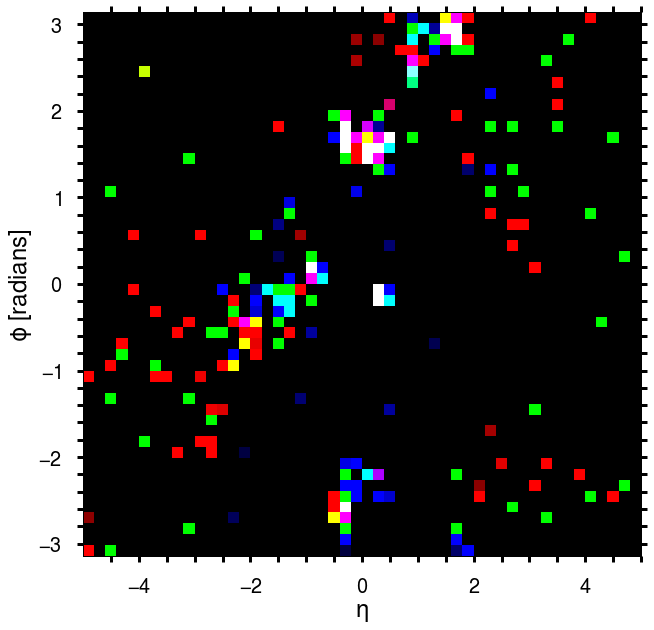

In [8]:
k = [6, 10, 15]
id = event_ids[0][k]
image = images[id[0]]
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at event", id[0])

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
cal_image_plot_paper(ax)
ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

tensor(0.9499)
tensor(0.9498)
tensor(0.9497)


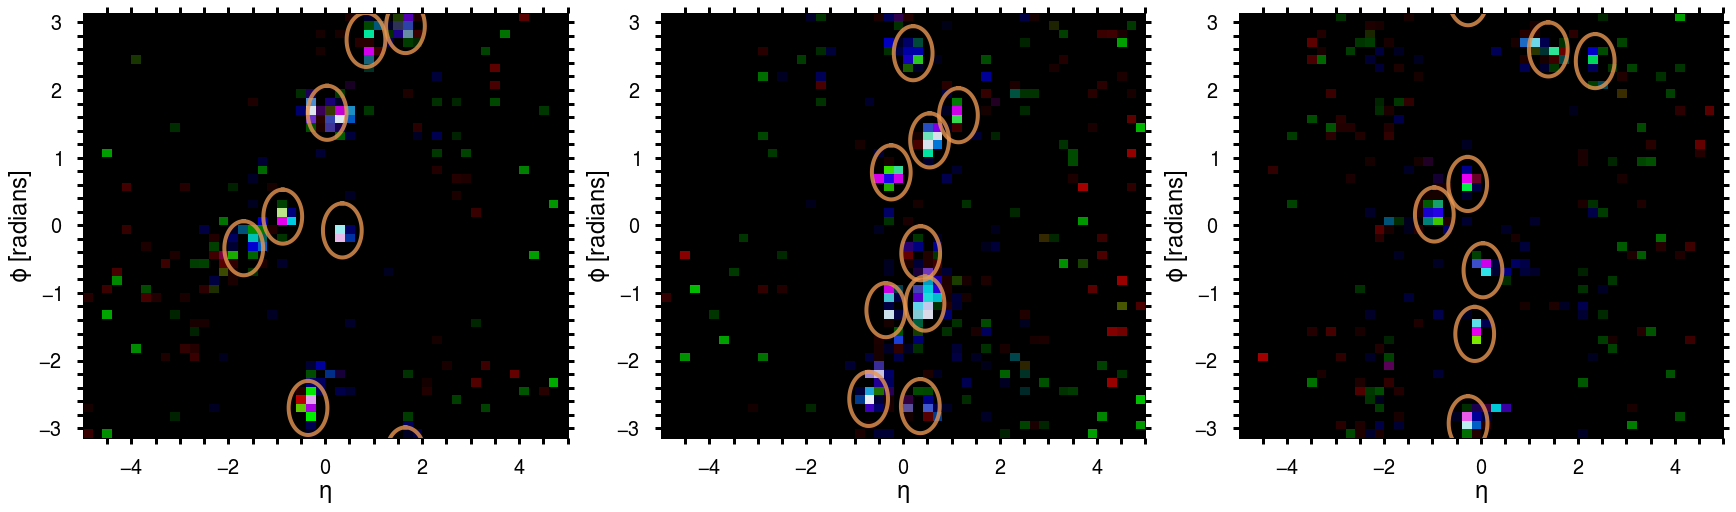

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 7), layout="constrained")

for j in range(len(id)):
    test_image = torch.Tensor(images[id[j]])
    test_image[:,:,2] = 6*test_image[:,:,2]
    new_image = torch.arctan(torch.log(test_image/20))/torch.pi + 0.5
    print(torch.max(new_image))

    ax[j].imshow(new_image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
    cal_image_plot_paper(ax[j])
    ax[j].set_xlim(-5, 5)
    ax[j].set_ylim(-np.pi, np.pi)
    ax[j].tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)
    
    #draw a circle where jets are
    jet_eta = jets[0]['Eta'][id[j]]
    jet_phi = jets[0]['Phi'][id[j]]
    for eta, phi in zip(jet_eta, jet_phi):
        r= 0.4
        angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
        ys = r*np.cos(angles) - phi
        xs = r*np.sin(angles) + eta
        ys_wrap = ys[abs(ys)>np.pi]
        xs_wrap = xs[abs(ys)>np.pi]
        ax[j].plot(xs, ys, color = '#e99652', linewidth=4, alpha=0.8)
        if len(ys_wrap)>0:
            if ys_wrap[0]>0:
                ax[j].plot(xs_wrap, -np.pi + (ys_wrap - np.pi) -0.05, color = '#e99652', linewidth=4, alpha=0.8)
            else:
                ax[j].plot(xs_wrap, np.pi + (ys_wrap + np.pi), color = '#e99652', linewidth=4, alpha=0.8)
    

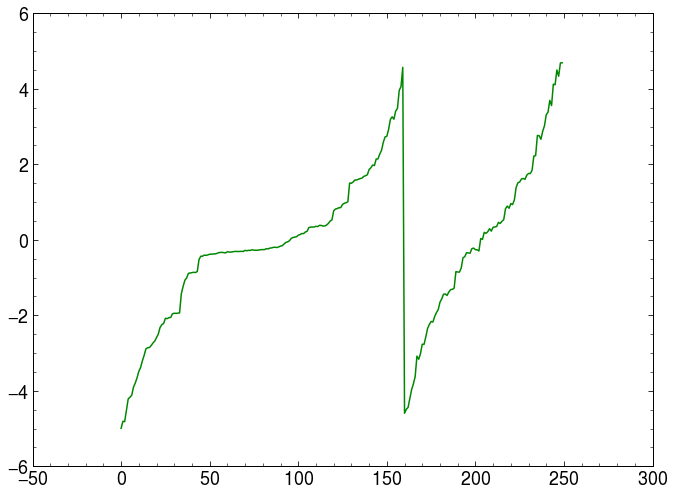

In [ ]:
plt.plot(clusters[0]['Eta'][id])

In [ ]:

np.set_printoptions(precision=5, suppress=True)
print("Ehad energy: \n")
print(f"{np.array(clusters[0]['Ehad'][id])}")
print("\n Eem energy: \n")
print(f"{np.array(clusters[0]['Eem'][id], dtype='float')}")
print("\n Eta: \n")
print(f"{np.array(clusters[0]['Eta'][id])}")
print("\n Phi: \n")
print(f"{np.array(clusters[0]['Phi'][id])}")
print("\n -------------- ")
print("-------------- \n")
print("\n Track energy: \n")
print(f"{np.array(tracks[0]['PT'][id])}")
print("\n Track Eta: \n")
print(f"{np.array(tracks[0]['Eta'][id])}")
print("\n Track Phi: \n")
print(f"{np.array(tracks[0]['Phi'][id])}")
 

Ehad energy: 

[   0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.     

In [ ]:


filename = f"{LABELS[0]}_eventid_{id}_cluster_values"
file = open(f"../results/{filename}.txt", "w")
file.write("Ehad energy: \n")
file.write(f"{np.array(clusters[0]['Ehad'][id])}")
file.write("\n Eem energy: \n")
file.write(f"{np.array(clusters[0]['Eem'][id], dtype='float')}")
file.write("\n Eta: \n")
file.write(f"{np.array(clusters[0]['Eta'][id])}")
file.write("\n Phi: \n")
file.write(f"{np.array(clusters[0]['Phi'][id])}")
file.write("\n -------------- ")
file.write("-------------- \n")
file.write("\n Track energy: \n")
file.write(f"{np.array(tracks[0]['PT'][id])}")
file.write("\n Track Eta: \n")
file.write(f"{np.array(tracks[0]['Eta'][id])}")
file.write("\n Track Phi: \n")
file.write(f"{np.array(tracks[0]['Phi'][id])}")

file.close()

    